In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
import analysis.yinf as yinf
import analysis.products as products
import analysis.util as util
from data.util import *
import os, sys, re
from scipy.stats import gaussian_kde, binned_statistic
ML_DIR = os.path.expandvars("$SCRATCH/mlreco_cell/")
NETS = dict(enumerate(sorted([d for d in os.listdir(os.path.expandvars(ML_DIR))])))
SIM_DIR = os.path.expandvars("$SCRATCH/larsim/")
SIMS = dict(enumerate(sorted([d for d in os.listdir(os.path.expandvars(SIM_DIR)) if "reco" in d])))

"""
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 15]
"""

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


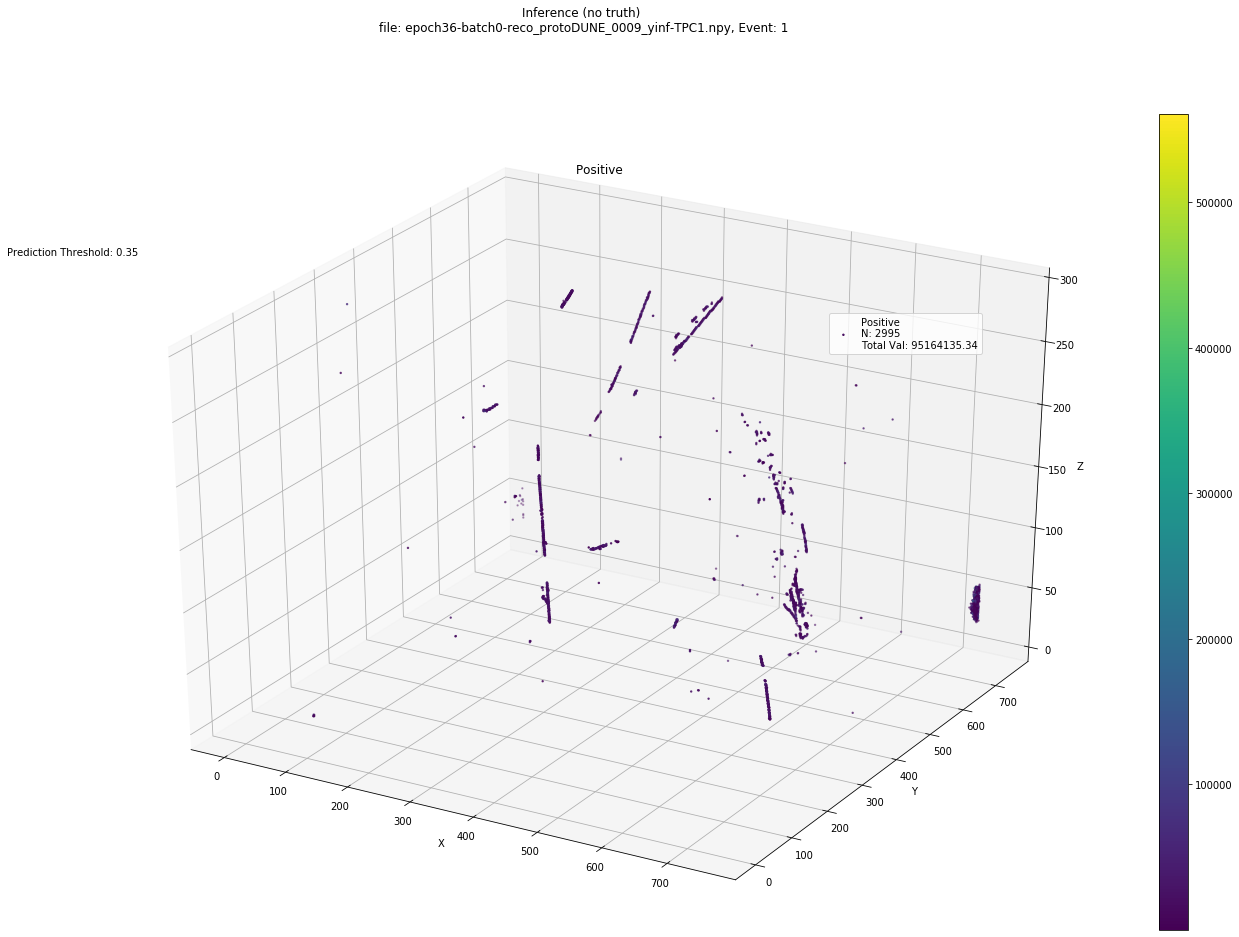

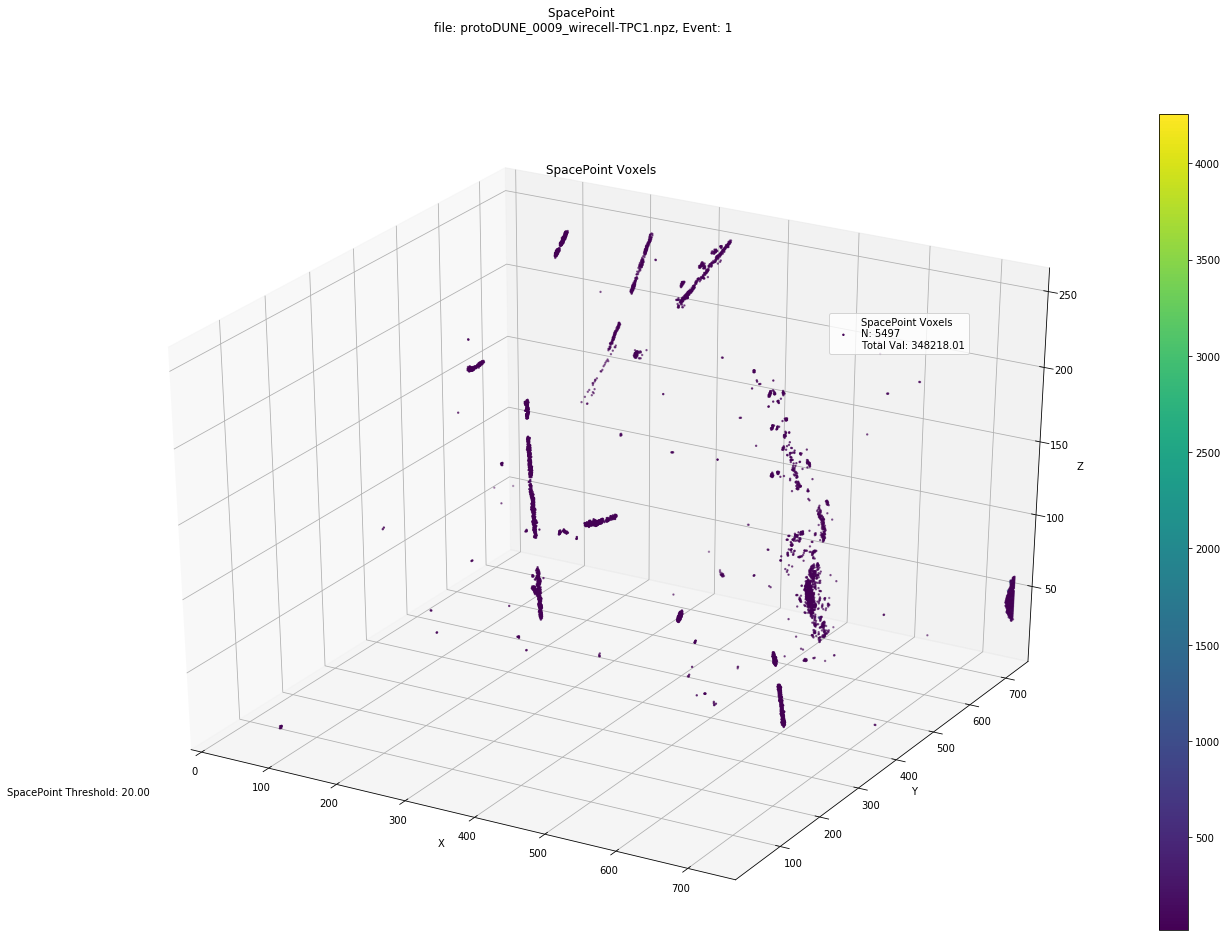

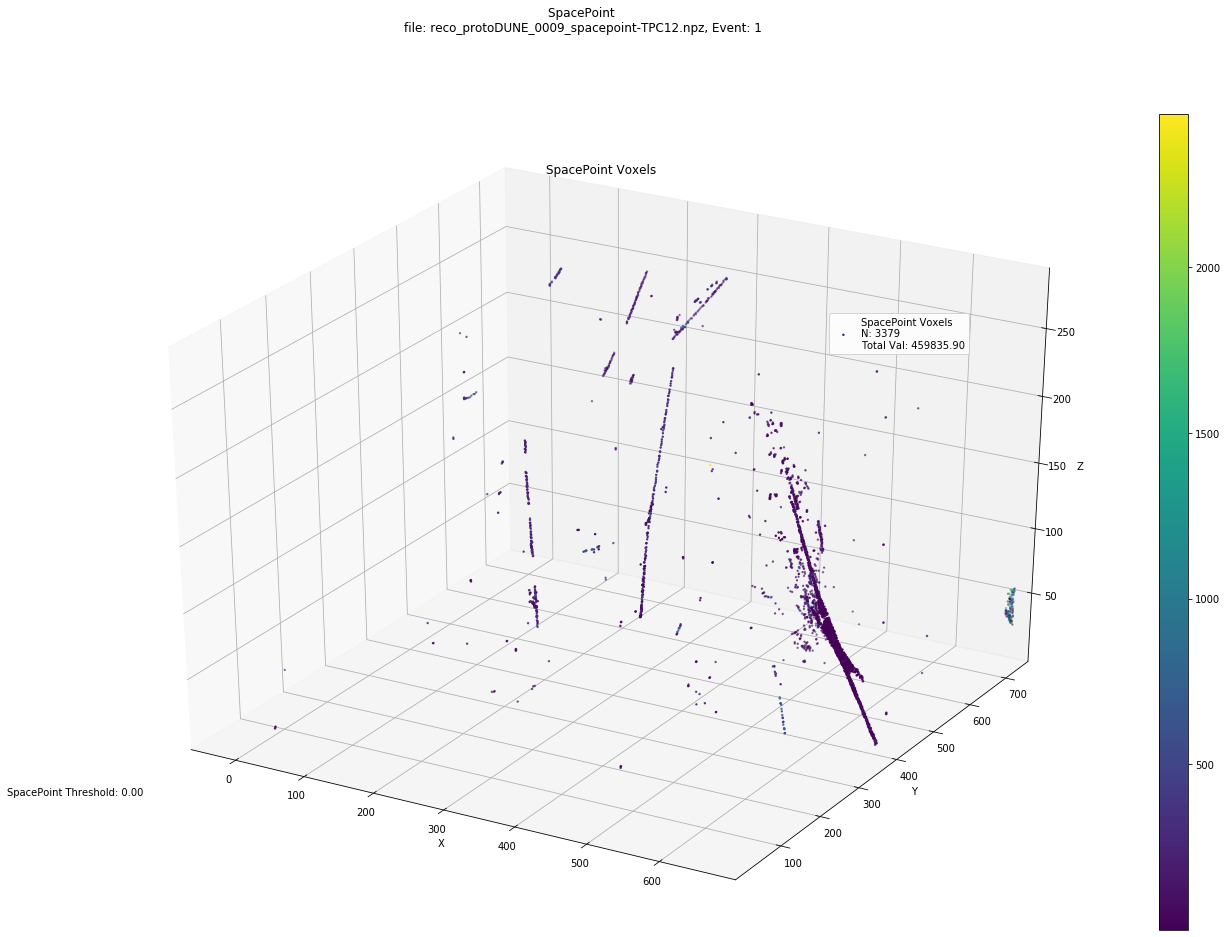

In [3]:
Electron = [1, 2, 3, 5, 11, 13, 14, 21]
event = 1
index=9
#lims = ((550, 600), (450, 550), (0, 100))
#lims = ((0, 550), None, None)
lims = ((0, 750), None, None)
yinf_file = (ML_DIR+"singleE-BeamCosmic-depoElec-tpc1_charge-164-lr0.01/inference/epoch36-batch0-reco_protoDUNE_%04d_yinf-TPC1.npy"%index,
    (ML_DIR+'singleE-BeamCosmic-tpc1_ghost3D-164-lr0.01/inference/epoch24-batch0-reco_protoDUNE_%04d_yinf-TPC1.npy'%index, 0.35))
yinf_inf=yinf.plot_yinf_notruth(plt.figure(), event, plot_active=False, thres=0.35, thres_active=10, plot_lims=lims, # plot_lims=((42,43), (180, 220), (460,490)), plot_slice=True,
                       xy_dir=SIM_DIR+"protoDUNE_xy", yinf_file=yinf_file)

#yinf_charge=yinf.plot_yinf_notruth(plt.figure(), event, plot_active=False, thres=0.01, thres_active=10, plot_lims=lims, # plot_lims=((42,43), (180, 220), (460,490)), plot_slice=True,
                       #xy_dir=SIM_DIR+"protoDUNE_xy", yinf_file='../ml/test/epoch24-batch0-reco_protoDUNE_%04d_yinf-TPC1.npz'%index)

products.plot_spacepoint(plt.figure(), None, event , (8, 4, 4), 20, -1, -1, lims, 
                    spacepoint_file=SIM_DIR+"protoDUNE_parsed/protoDUNE_%04d_wirecell-TPC1.npz"%index, truth_file=None)

products.plot_spacepoint(plt.figure(), None, event , (8, 4, 4), 0, -1, -1, ((lims[0][0]-62.5, lims[0][1]-62.5), lims[1], lims[2]), 
                    spacepoint_file=SIM_DIR+"protoDUNE_parsed/reco_protoDUNE_%04d_spacepoint-TPC12.npz"%index, truth_file=None)

34
43


'\nplt.figure()\nplt.plot(*QvR, "bo", markersize=2)\nplt.plot(QvR[0], np.array(QvE[0])*100, "ro", markersize=2)\ntry:\n    bin_means, bin_edges, binnumber = binned_statistic(*QvR, bins=50)\n    plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors=\'y\', lw=5,\n               label=\'binned statistic of data\')\n    bin_means, bin_edges, binnumber = binned_statistic(QvR[0], np.array(QvE[0])*100, bins=50)\n    plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors=\'purple\', lw=5,\n               label=\'binned statistic of data\')\nexcept Exception:\n    pass\n\nplt.figure()\nplt.scatter(*QvE, s=5)\nplt.figure()\nplt.hist([[v for k, v in voxel.items()] for voxel in voxel_planes], histtype=\'step\', label=range(3))\nplt.legend()\nplt.show()\n'

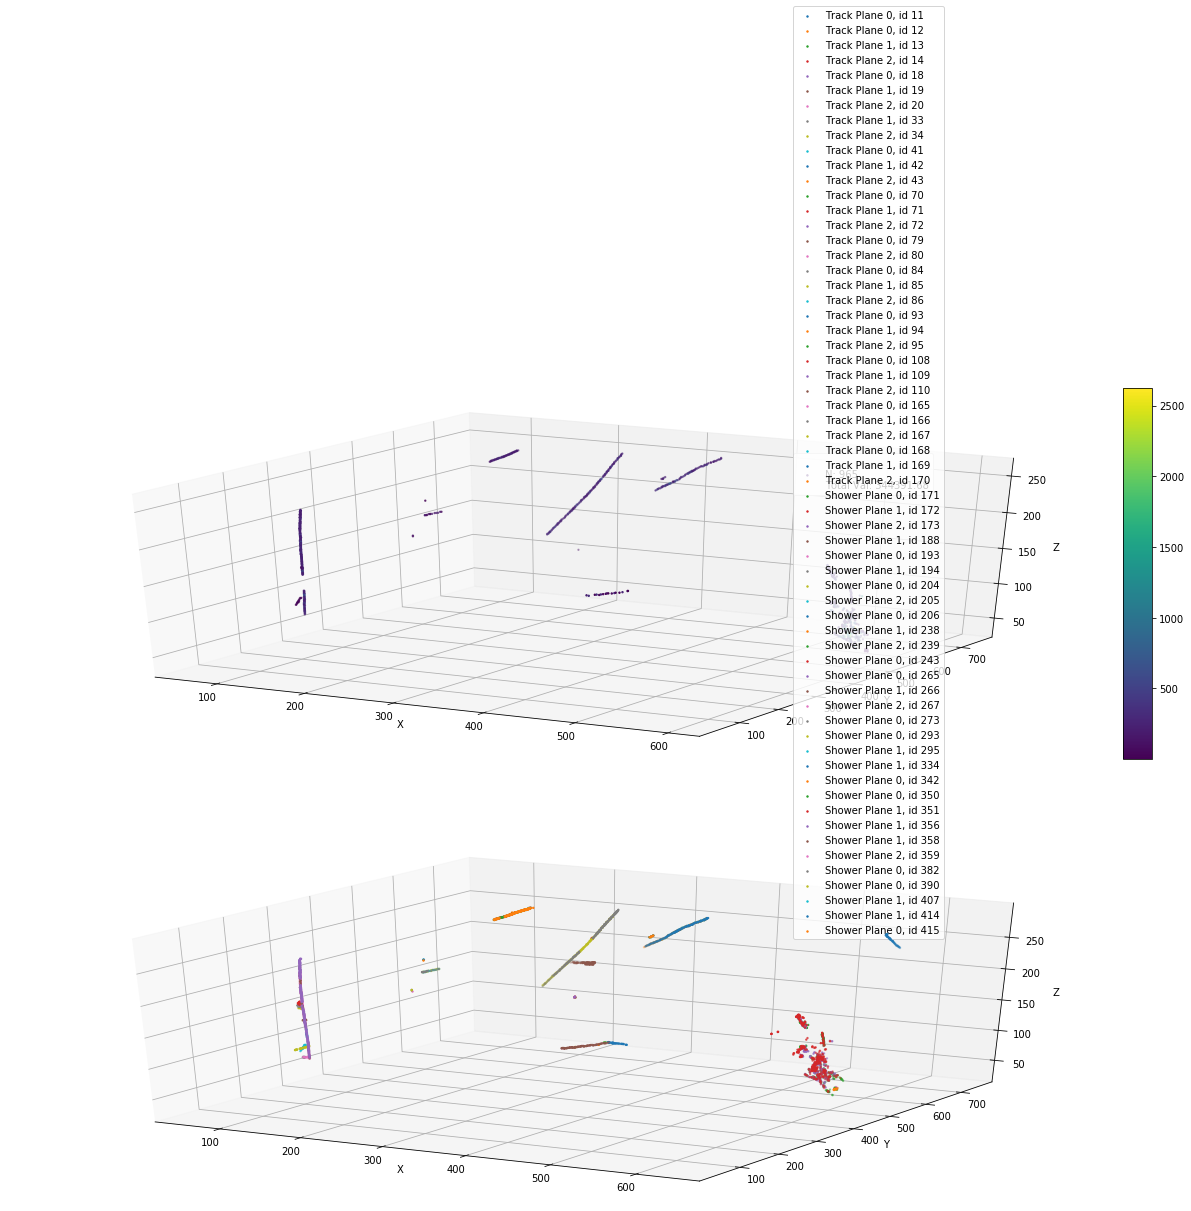

In [4]:
downsample = (8,4,4)
#downsample = (1,1,1)
tpc_lims = np.array((3585//(1.565/2), 5984//2, 2300//2))

with np.load(SIM_DIR+"protoDUNE_parsed/reco_protoDUNE_%04d_calonosce-TPC1.npz"%index, allow_pickle=True) as f:
    voxels = []
    names = []
    voxel_planes = [{}, {}, {}]
    QvR = [[], []]
    QvE = [[], []]
    for i, calo in enumerate(f["arr_%d"%event]):
        if len(calo) <= 3: continue
        attr, plane, energy = calo[:3]
        pts = np.vstack(calo[3:])
        pts[:, 0] -= 12
        in_tpc = np.all((tpc_lims-pts[np.argmin(pts[:, 5])][:3])>100) and np.all(pts[np.argmin(pts[:, 5])][:3]>100)
        #if plane != 2: continue
        #if len(calo)<10: continue
        #if not (plane == 2 and attr=="Track" and np.min(pts[:, 5]) < 1 and in_tpc and len(calo)>100): continue
        #if attr!="Track": continue
        #if attr!="Shower": continue
        #if i != 5: continue
        #print(calo[1], energy)
        voxels.append(util.downsample_voxels(downsample, {(pt[0], pt[1], pt[2]): pt[3] for pt in pts}, reduce=True, avg=True)[0])
        names.append(attr+" Plane %d, id %d"%(plane, i))
        voxel_planes[plane].update(voxels[-1])
        if plane == 2 and attr=="Track" and np.min(pts[:, 5]) < 1 and in_tpc and len(calo)>100:
            QvR[1].extend(pts[:, 3])
            QvR[0].extend(pts[:, 5])
            QvE[1].extend(pts[:, 3])
            QvE[0].extend(pts[:, 4])    
            print(i)
    fig = plt.figure()
    util.scatter_voxel(fig, fig.add_subplot(211, projection="3d"), voxel_planes[2])
    util.scatter_voxels(fig, fig.add_subplot(212, projection="3d"), voxels, names)
    
"""
plt.figure()
plt.plot(*QvR, "bo", markersize=2)
plt.plot(QvR[0], np.array(QvE[0])*100, "ro", markersize=2)
try:
    bin_means, bin_edges, binnumber = binned_statistic(*QvR, bins=50)
    plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='y', lw=5,
               label='binned statistic of data')
    bin_means, bin_edges, binnumber = binned_statistic(QvR[0], np.array(QvE[0])*100, bins=50)
    plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='purple', lw=5,
               label='binned statistic of data')
except Exception:
    pass

plt.figure()
plt.scatter(*QvE, s=5)
plt.figure()
plt.hist([[v for k, v in voxel.items()] for voxel in voxel_planes], histtype='step', label=range(3))
plt.legend()
plt.show()
"""

Text(0.5, 0.98, 'Wirecell')

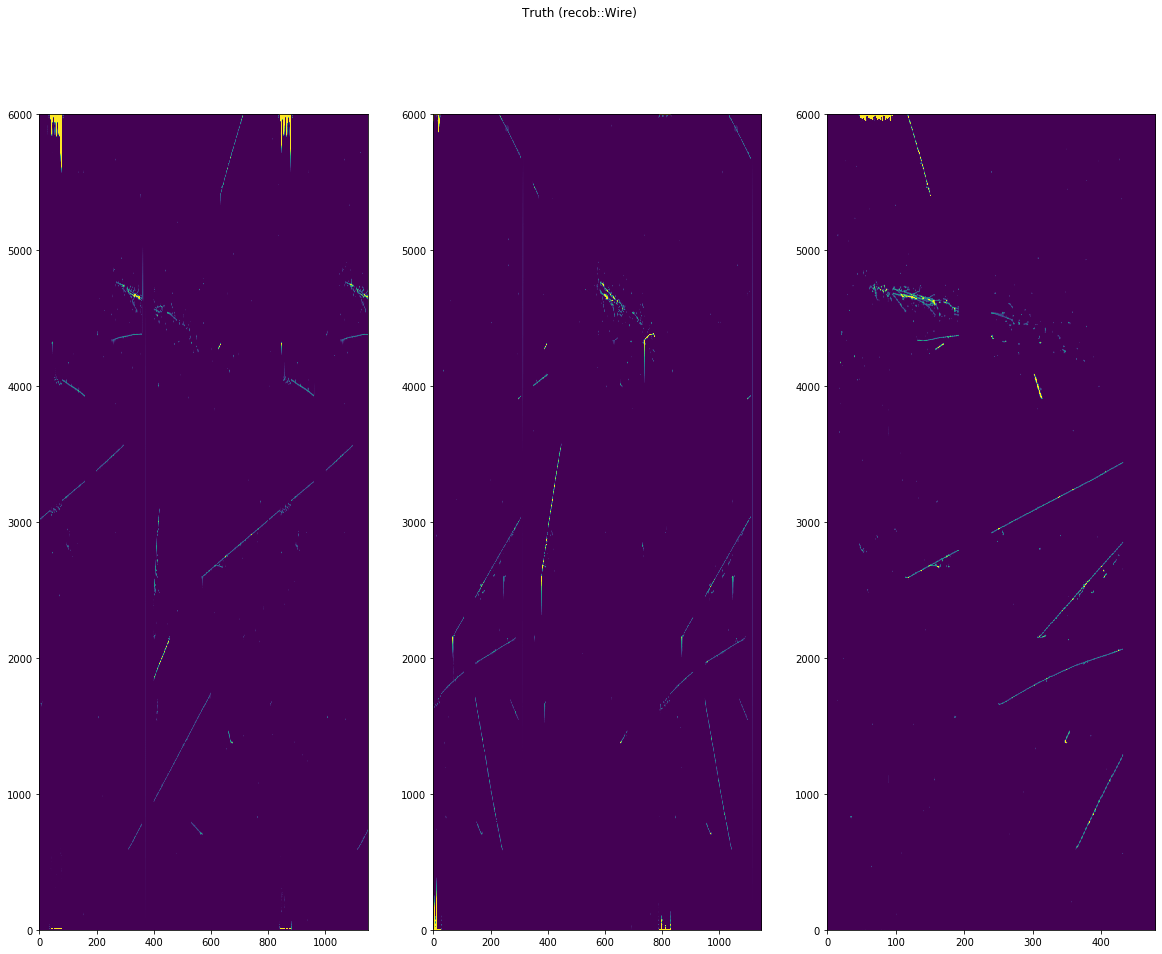

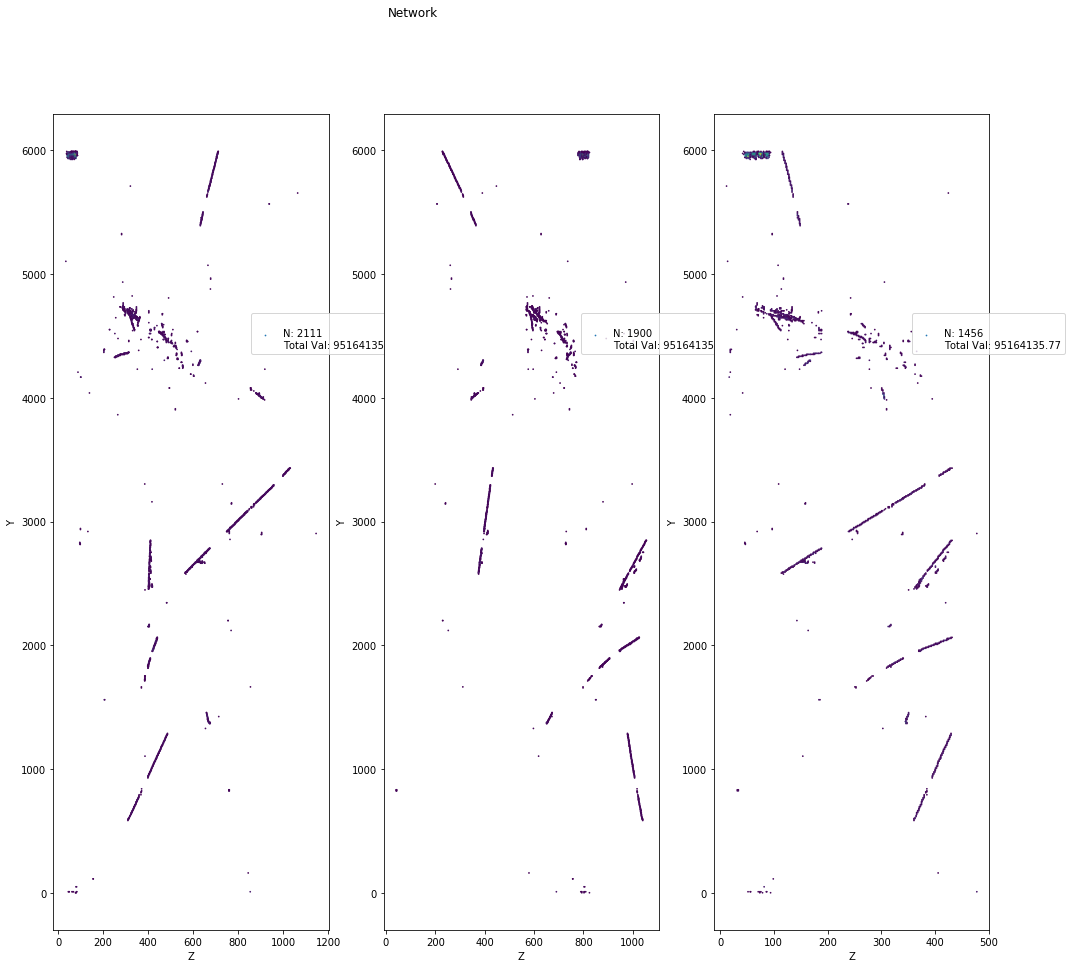

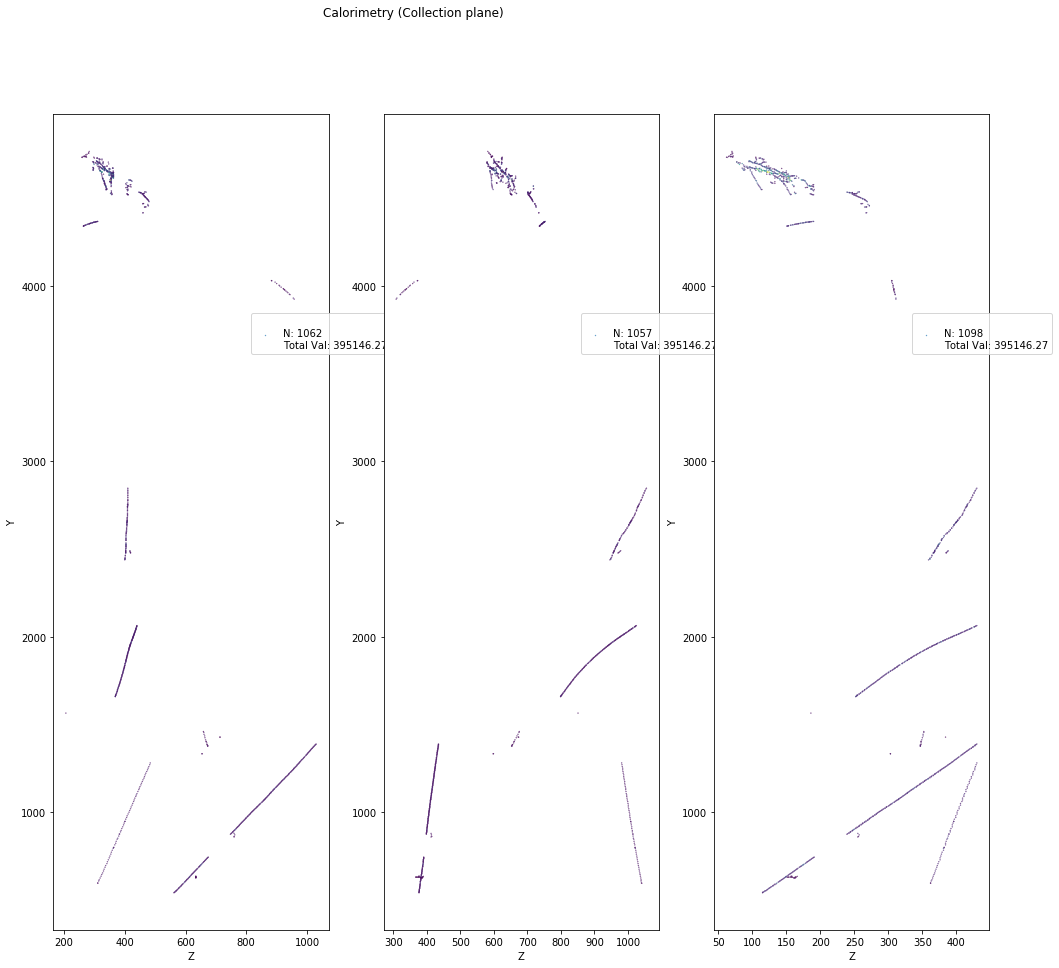

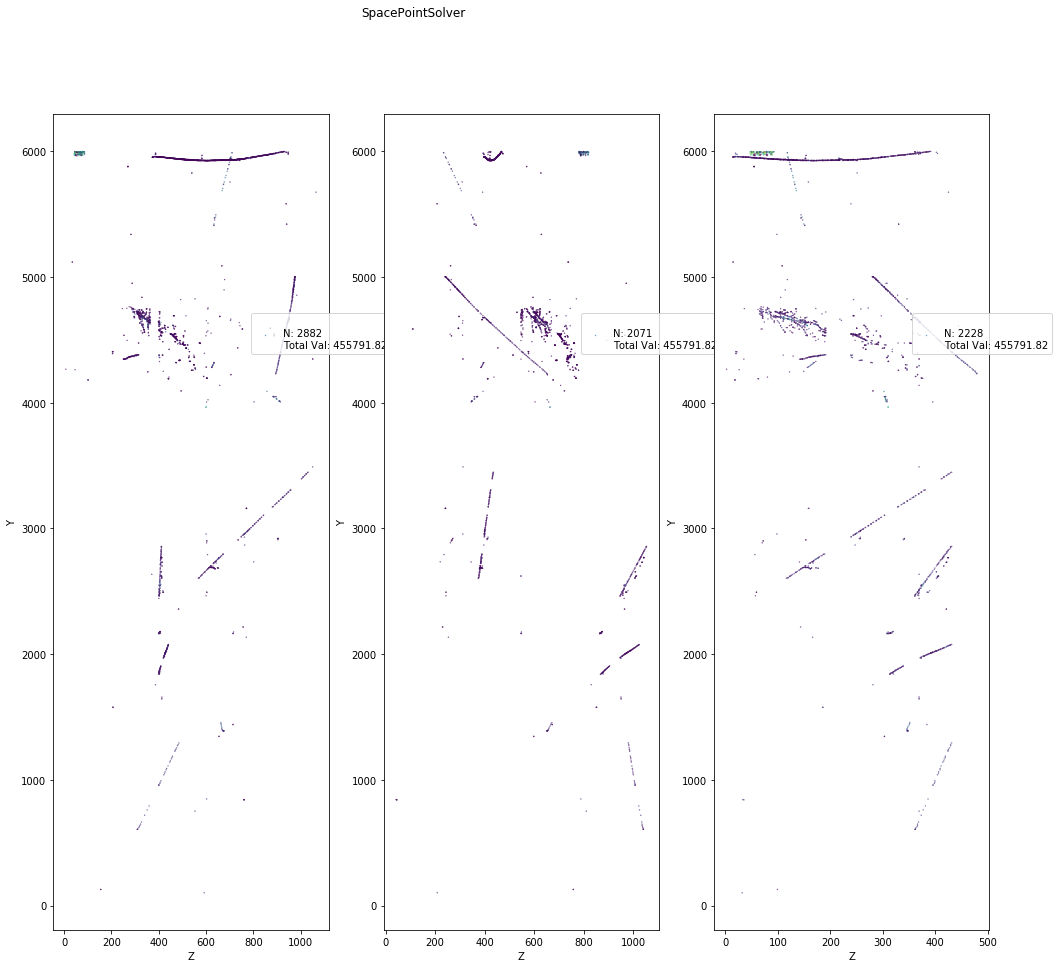

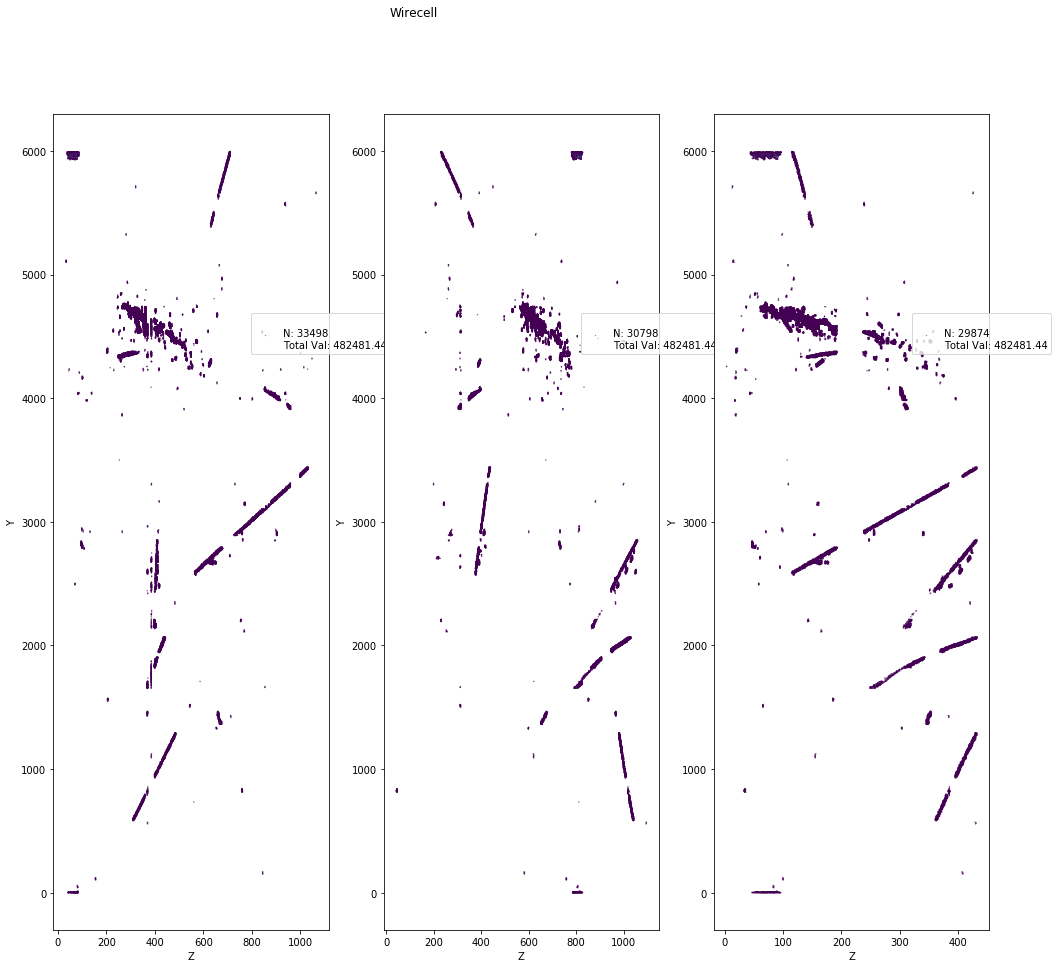

In [5]:
#x_lim = (500, 2300)
x_lim = (0, 6000)

products.plot_channel(plt.figure(), event, x_lim, SIM_DIR+"protoDUNE_parsed/reco_protoDUNE_%04d_wire-TPC1.npz"%index)
plt.suptitle("Truth (recob::Wire)")
yinf_file = (ML_DIR+"singleE-BeamCosmic-depoElec-tpc1_charge-164-lr0.01/inference/epoch36-batch0-reco_protoDUNE_%04d_yinf-TPC1.npy"%index,
    (ML_DIR+'singleE-BeamCosmic-tpc1_ghost3D-164-lr0.01/inference/epoch24-batch0-reco_protoDUNE_%04d_yinf-TPC1.npy'%index, 0.35))

#yinf_file = '../ml/test/epoch24-batch0-reco_protoDUNE_%04d_yinf-TPC1.npz'%index

util.plot_voxel_projection(plt.figure(), util.filter_voxels_coord((x_lim, None, None), 
                                util.downsample_voxels(np.reciprocal((8., 4., 4.)), 
                                yinf.parse_yinf((event, SIM_DIR+"protoDUNE_xy/"), yinf_file), reduce=True)[0])[0], 0.5)
plt.suptitle("Network")

with np.load(SIM_DIR+"protoDUNE_parsed/reco_protoDUNE_%04d_calonosce-TPC1.npz"%index, allow_pickle=True) as f:
    voxels = []
    names = []
    voxel_planes = [{}, {}, {}]
    for calo in f["arr_%d"%event]:
        if len(calo) <= 3: continue
        attr, plane, energy = calo[:3]
        pts = np.vstack(calo[3:])
        pts[:, 0] -= 12
        #in_tpc = np.all((tpc_lims-pts[np.argmin(pts[:, 5])][:3])>100) and np.all(pts[np.argmin(pts[:, 5])][:3]>100)
        #if not (plane == 2 and attr=="Track" and np.min(pts[:, 5]) < 1 and in_tpc and len(calo)>100): continue
        voxels.append({tuple(pt[:3]): pt[3] for pt in pts})
        voxel_planes[plane].update(voxels[-1])
util.plot_voxel_projection(plt.figure(), util.filter_voxels_coord((x_lim, None, None), voxel_planes[2])[0])
plt.suptitle("Calorimetry (Collection plane)")
with np.load(SIM_DIR+"protoDUNE_parsed/reco_protoDUNE_%04d_spacepoint-TPC12.npz"%index) as f:
    voxel_spacepoint = {(pt[0]+500, pt[1], pt[2]): pt[3] for pt in f["arr_%d"%event]}
with np.load(SIM_DIR+"protoDUNE_parsed/protoDUNE_%04d_wirecell-TPC1.npz"%index) as f:
    voxel_wirecell = {tuple(pt[:3]): pt[3] for pt in f["arr_%d"%event]}

util.plot_voxel_projection(plt.figure(), util.filter_voxels_coord((x_lim, None, None), voxel_spacepoint)[0])
plt.suptitle("SpacePointSolver")
util.plot_voxel_projection(plt.figure(), util.filter_voxels_coord((x_lim, None, None), voxel_wirecell)[0])
plt.suptitle("Wirecell")